# Transporter analysis of bacillus mother-spore

In [26]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *

import copy

%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [27]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [28]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [29]:
# Previously identified essential metabolites
exchange_list = ['4fe4s_s','2fe2s_s','udcpp_s','pydx5p_s','3fe4s_s','cl_s','sheme_s','cu_s','mn2_s',
                 'bmocogdp_s','dpm_s','thmpp_s','zn2_s','cbl1_s','cobalt2_s']
additional = [m.id for m in sporeme.metabolites if isinstance(m,cobrame.Metabolite)]
transported_metabolites = exchange_list+additional

In [30]:
# Get transport reactions

def get_compartments(r):
    comps = []
    if isinstance(r,cobrame.MetabolicReaction):
        for m in r.metabolites:
            if isinstance(m,cobrame.Metabolite):
                comps.append(m.id[-1])
    return list(set(comps))

def get_all_transport(model):
    transport_reactions = []
    for r in tqdm(model.reactions):
        comps = get_compartments(r)
        if len(comps) > 1 and 's' in comps:
            transport_reactions.append(r.id)
    return list(set(transport_reactions))

def get_active_transport(transport_reactions):
    active_transporters = []
    for r in tqdm(transport_reactions):
        if 'SPONT' not in r and abs(sporeme.solution.x_dict[r])>0.:
            active_transporters.append(r)
    # Include arginine transport
    arginine_transport = [r.id for r in get_transport_reactions(sporeme,'arg__L_c',comps=['c','s'])+get_transport_reactions(sporeme,'arg__L_c',comps=['s','c'])]
    [active_transporters.append(r) for r in arginine_transport]
    active_transporters = list(set(active_transporters))
    return active_transporters

In [43]:
transport_reactions = get_all_transport(sporeme)
print('{} transport reactions identified'.format(len(transport_reactions)))























  0%|          | 0/12339 [00:00<?, ?it/s]





















100%|██████████| 12339/12339 [00:00<00:00, 99667.83it/s] 

405 transport reactions identified


Text(0, 0.5, 'Count')

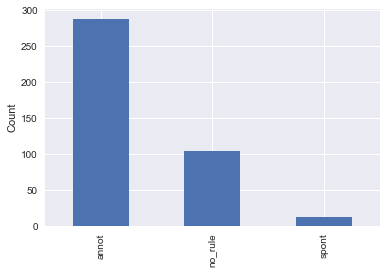

In [48]:
count = {'no_rule':0,'spont':0,'annot':0}
for r in transport_reactions:
    if 'dummy' in r:
        count['no_rule']+=1
    elif 'SPONT' in r:
        count['spont']+=1
    else:
        count['annot']+=1
pd.DataFrame.from_dict({'count':count}).plot.bar(figsize=(6,4),legend=False)
plt.ylabel('Count')

In [7]:
active_transporters = get_active_transport(transport_reactions)

100%|██████████| 405/405 [00:00<00:00, 140597.01it/s]


In [8]:
print('{} active transport reactions identified'.format(len(active_transporters)))

54 active transport reactions identified


In [9]:
for r in transport_reactions:
    if r not in active_transporters and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [ ]:
solve_me_model(sporeme, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,active_transporters, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
flux_results_df.to_csv('comm_transport_flux_results.csv')

In [ ]:
# All of them:
flux_results_df = pd.read_csv('comm_transport_flux_results.csv',index_col=0)
(n, bins, patches) = plt.hist(flux_results_df.loc['biomass_dilution_s'])
plt.xlabel('Growth rate')
plt.ylabel('Counts')

In [ ]:
transport_dict = {}
for candidate in flux_results_df.drop('base',axis=1).columns:
    r = sporeme.reactions.get_by_id(candidate)
    mets = []
    [mets.append(re.split('_.$',m.id)[0]) for m in r.metabolites if isinstance(m,cobrame.Metabolite) and 'h_' not in m.id]
    mets = list(set(mets))
    transport_dict[candidate] = mets[0]
    
plt.figure(figsize=(13,3))
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar()
plt.xlabel('Single knockout')
plt.ylabel('Spore growth rate')

In [ ]:
# Important transporters without gene so far
df = flux_results_df.loc['biomass_dilution_s'].sort_values().head(20)
df[df.index.str.contains('dummy')]

In [ ]:
output = flux_results_df.loc[flux_results_df.columns.to_list()+['biomass_dilution_s']]
output = output[output.any(axis=1)] # Only reactions that carried flux in at least one knockout

In [ ]:
plt.figure(figsize = (13,5))
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
cluster_df = cluster_df.loc[:,output.loc['biomass_dilution_s']<bins[-1]]
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap="mako")
plt.savefig('clustermap_filtered')

Identify essential transporters so far. These are stored and taken out as they are already results.

In [ ]:
essential_transporters = list(output.columns[output.loc['biomass_dilution_s'] < 0.001])
non_essential_transporter = list(output.columns[output.loc['biomass_dilution_s'] >= bins[-1]])

# Remove non-essential
candidates_df = output.drop(non_essential_transporter,axis=1)
# Remove the ones that we now already are essential
candidates_df = candidates_df.drop(essential_transporters,axis=1)

print('{} transporters are obviously non-essential: {} \n'.format(len(non_essential_transporter),non_essential_transporter))
print('So far, {} transporters are obviously essential: {} \n'.format(len(essential_transporters),essential_transporters))

print('There are {} candidates: {} \n'.format(len(candidates_df.columns),candidates_df.columns.values))

In [ ]:
# The rest:
(n, bins, patches) = plt.hist(candidates_df.loc['biomass_dilution_s'])
plt.xlabel('Growth rate')
plt.ylabel('Counts')

In [ ]:
output = candidates_df.loc[candidates_df.columns.to_list()+['biomass_dilution_s']]
output = output[output.any(axis=1)] # Only reactions that carried flux in at least one knockout

In [ ]:
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
cm = sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap="mako",yticklabels=1,xticklabels=1)

plt.savefig('clustermap_filtered')

In [ ]:
# 1. Pairwise interaction knockout
# 2. Find minimal set of transporters. Sort values and close less essential first. 
# Ignore those transporters that are not active. Restore them if they are turned on again to compensate.
# 3. Do these simulations change with different NGAM?

## Pairwise interaction

In [ ]:
from bacillusme.analysis import sensitivity as ss
transport_reactions_filtered = cluster_df.columns.values
base_model = copy.deepcopy(sporeme)

In [ ]:
from scipy.special import binom
print('With {} knockouts there can be {} pairs'.format(len(transport_reactions_filtered),binom(len(transport_reactions_filtered),2)))

In [ ]:
for r in transport_reactions_filtered:
    # Restore
    sporeme = copy.deepcopy(base_model)
    
    # Close transporter
    rxn = sporeme.reactions.get_by_id(r)
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    
    # Calculation
    flux_results_df = ss.transporter_knockout(sporeme,transport_reactions_filtered, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
    flux_results_df.to_csv('transporter_knockouts/{}.csv'.format(r))

In [ ]:
# Read and process
gr_df = pd.DataFrame(index=transport_reactions_filtered)
for r in transport_reactions_filtered:
    flux_results_df=pd.read_csv('transporter_knockouts/{}.csv'.format(r),index_col=0).drop('base',axis=1)
    for i in transport_reactions_filtered:
        gr_df.loc[r,i] = flux_results_df.loc['biomass_dilution_s',i]

In [ ]:
plt.figure(figsize = (13,5))
output = gr_df.loc[gr_df.any(axis=1),gr_df.any(axis=0)].drop('H2Ot_FWD_CPLX_dummy_s',axis=0).drop('H2Ot_FWD_CPLX_dummy_s',axis=1)
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(output,col_cluster=1,row_cluster=1, cmap='mako')
plt.savefig('pairwise_growth')

## Check for other possible transporters

Close each one of the active 51 transporters and check for all other transporters that might turn on. Then include all in the analysis.

In [ ]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
closed_flux_results_df = pd.read_csv('comm_transport_flux_results.csv',index_col=0).drop('base',axis=1)

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,active_transporters, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
flux_results_df.to_csv('single_ko_all_open.csv')

In [ ]:
flux_results_df = pd.read_csv('single_ko_all_open.csv',index_col=0)

In [ ]:
new_transporters = []
for r in transport_reactions:
    if (flux_results_df.loc[r]>0).any() and r not in active_transporters:
        new_transporters.append(r)
        
        print('REACTION:',r,flux_results_df.loc[r,'base'])
        print(flux_results_df[flux_results_df.columns[flux_results_df.loc[r]>0]].loc[r])
        print('\n')

In [ ]:
include_transporters = new_transporters
output = flux_results_df.loc[include_transporters,active_transporters]

In [ ]:
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1, cmap='mako',yticklabels=1,xticklabels=1,figsize=(13,13))
plt.savefig('transporters_turned_on')

### Mini robustness

In [ ]:
transport_reactions = ['ASPt2r_FWD_CPLX_dummy_s','4FE4St_s','PSER_Lt6_FWD_CPLX_dummy_s','CBL1t_s']

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,transport_reactions, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',overexpress=True)
flux_results_df.to_csv('overexpress_flux_results.csv')

In [ ]:
flux_results_df = pd.read_csv('overexpress_flux_results.csv',index_col=0)

In [ ]:
output = flux_results_df.loc[flux_results_df.columns.to_list()+['biomass_dilution_s']]
output = output[output.any(axis=1)] # Only reactions that carried flux in at least one knockout

In [ ]:
plt.figure(figsize = (13,5))
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap="mako")
plt.savefig('clustermap_filtered')

## Check by group of transporters of metabolite

In [10]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [9]:
def get_necessary_metabolites(model,active_transporters):
    necessary_metabolites = []
    for r in tqdm(active_transporters):
        rxn = model.reactions.get_by_id(r)
        for m in rxn.products:
            if not isinstance(m,cobrame.Metabolite):
                continue
            met_root = m.id[:-2]
            for i in rxn.reactants:
                if met_root in i.id:
                    necessary_metabolites.append(m.id)
    return list(set(necessary_metabolites))

def get_all_available_transport(model,necessary_metabolites):
    available_transport = []
    at_dict = {}
    for m in tqdm(necessary_metabolites):
        rxns = get_transport_reactions(model,m,comps=['c','s']) + get_transport_reactions(model,m,comps=['s','c'])
        [available_transport.append(r.id) for r in rxns]
        at_dict[m] = []
        [at_dict[m].append(r.id) for r in rxns]
    return list(set(available_transport)), at_dict

In [10]:
# Previously identified essential metabolites
exchange_list = ['4fe4s_s','2fe2s_s','udcpp_s','pydx5p_s','3fe4s_s','cl_s','sheme_s','cu_s','mn2_s',
                 'bmocogdp_s','dpm_s','thmpp_s','zn2_s','cbl1_s','cobalt2_s']
additional = [m.id for m in sporeme.metabolites if isinstance(m,cobrame.Metabolite)]
transported_metabolites = exchange_list+additional

In [11]:
transport_reactions = get_all_transport(sporeme)
print('{} transport reactions identified'.format(len(transport_reactions)))

100%|██████████| 12339/12339 [00:00<00:00, 90983.36it/s]

405 transport reactions identified


In [12]:
active_transporters = get_active_transport(transport_reactions)
necessary_metabolites = get_necessary_metabolites(sporeme,active_transporters)
necessary_metabolites.remove('h_s')
necessary_metabolites.remove('h_c')
available_transport, at_dict = get_all_available_transport(sporeme,necessary_metabolites)

100%|██████████| 51/51 [00:01<00:00, 36.53it/s]


In [13]:
print('{} active transport reactions identified'.format(len(active_transporters)))
print('{} necessary metabolites identified'.format(len(necessary_metabolites)))
print('{} available transport reactions identified'.format(len(available_transport)))

54 active transport reactions identified
51 necessary metabolites identified
127 available transport reactions identified


In [14]:
all_transporters_to_open = list(set(active_transporters + available_transport))
print('{} open transport reactions identified'.format(len(all_transporters_to_open)))
print('Included {}'.format(set(active_transporters)-set(available_transport)))

129 open transport reactions identified
Included {'GLCpts_FWD_BSU13890-MONOMER_s', 'ATPS4r_FWD_CPLX000-10_s'}


In [17]:
for r in transport_reactions:
    if r not in all_transporters_to_open and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [19]:
solve_me_model(sporeme, max_mu = 0.15, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 458.311061 seconds
Finished substituting S,lb,ub in 19.991355 seconds
Finished makeME_LP in 2.215100 seconds
Getting MINOS parameters from ME_NLP...
1 0.075 0.075 0.15 0.075 optimal
Finished substituting S,lb,ub in 20.147968 seconds
Finished makeME_LP in 2.209548 seconds
Getting MINOS parameters from ME_NLP...
2 0.11249999999999999 0.11249999999999999 0.15 0.11249999999999999 optimal
Finished substituting S,lb,ub in 19.398486 seconds
Finished makeME_LP in 2.307412 seconds
Getting MINOS parameters from ME_NLP...
3 0.11249999999999999 0.11249999999999999 0.13124999999999998 0.13124999999999998 1
Finished substituting S,lb,ub in 19.748151 seconds
Finished makeME_LP in 2.185317 seconds
Getting MINOS parameters from ME_NLP...
4 0.11249999999999999 0.11249999999999999 0.12187499999999998 0.12187499999999998 1
Finished substituting S,lb,ub in 19.552347 seconds
Finished makeME_LP in 2.191740 seconds
Getting MINOS p

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,necessary_metabolites, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout')

Chosen change function: group_knockout      Sequential = False


biomass_dilution_s response (10 threads):   0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
flux_results_df.to_csv('group_KO_flux_results.csv')

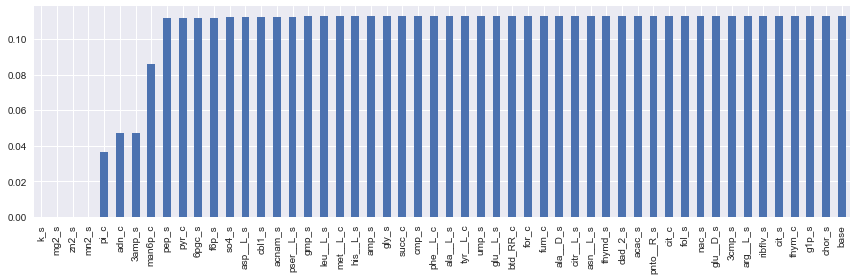

In [94]:
flux_results_df = pd.read_csv('group_KO_flux_results.csv',index_col=0)
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar(figsize=(12,4))
plt.tight_layout()
plt.savefig("group_KO_flux_results.svg", format="SVG")

### Close metabolite one by one
Including information about arginine being transported

In [20]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [21]:
for r in transport_reactions:
    if r not in all_transporters_to_open and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [22]:
flux_results_df = pd.read_csv('group_KO_flux_results.csv',index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=False).drop('base').index.to_list()

In [23]:
sorted_mets.remove('arg__L_s')
sorted_mets.append('arg__L_s')

In [ ]:
# flux_dict = {}
# b = 0
# for met in tqdm(sorted_mets):
#     transport = at_dict[met]
    
#     if b == 1:
#         flux_dict[met] = {r.id:0. for r in sporeme.reactions}
#         continue
    
#     for r in transport:
#         rxn = sporeme.reactions.get_by_id(r)
#         rxn.lower_bound = 0
#         rxn.upper_bound = 0
#     solve_me_model(sporeme, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-4,growth_key = 'sigma',
#                   verbosity = 0)
#     if sporeme.solution:
#         flux_dict[met] = sporeme.solution.x_dict
#     else:
#         flux_dict[met] = {r.id:0. for r in sporeme.reactions}
#         b = 1
# flux_results_df = pd.DataFrame.from_dict(flux_dict)


In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,sorted_mets, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout',sequential=True)
flux_results_df.to_csv('group_1by1_KO_flux_results.csv')

Chosen change function: group_knockout      Sequential = True


biomass_dilution_s response (20 threads):  59%|█████▉    | 30/51 [1:06:57<39:06, 111.72s/it]  

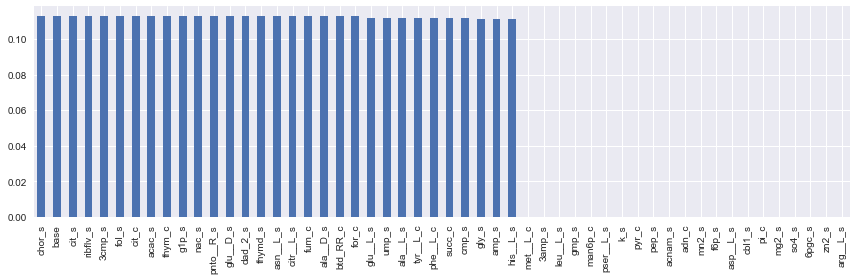

In [92]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results.csv',index_col=0)
flux_results_df.loc['biomass_dilution_s',sorted_mets[::-1]].plot.bar(figsize=(12,4))
plt.tight_layout()
plt.savefig("group_1by1_KO_flux_results.svg", format="SVG")

#### Essential mets

In [183]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [184]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results.csv',index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=True).index.to_list()
essential_mets = sorted_mets[:sorted_mets.index('met__L_c')+1]
print('Essential metabolites: {}'.format(essential_mets))

Essential metabolites: ['arg__L_s', 'zn2_s', '6pgc_s', 'so4_s', 'mg2_s', 'pi_c', 'cbl1_s', 'asp__L_s', 'f6p_s', 'mn2_s', 'adn_c', 'acnam_s', 'pep_s', 'pyr_c', 'k_s', 'pser__L_s', 'man6p_c', 'gmp_s', 'leu__L_s', '3amp_s', 'met__L_c']


In [185]:
essential_transporters = []
for met in essential_mets:
    [essential_transporters.append(i) for i in at_dict[met]]

In [186]:
print('{} essential open transporters'.format(len(essential_transporters)))

63 essential open transporters


In [187]:
for r in transport_reactions:
    if r not in essential_transporters and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [40]:
solve_me_model(sporeme, max_mu = 0.15, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 419.896291 seconds
Finished substituting S,lb,ub in 18.152458 seconds
Finished makeME_LP in 2.073279 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.075 0.075 1
Finished substituting S,lb,ub in 18.030050 seconds
Finished makeME_LP in 2.020010 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.0375 0.0375 1
Finished substituting S,lb,ub in 18.068915 seconds
Finished makeME_LP in 2.028888 seconds
Getting MINOS parameters from ME_NLP...
3 0.01875 0.01875 0.0375 0.01875 optimal
Finished substituting S,lb,ub in 18.030855 seconds
Finished makeME_LP in 2.034919 seconds
Getting MINOS parameters from ME_NLP...
4 0.028124999999999997 0.028124999999999997 0.0375 0.028124999999999997 optimal
Finished substituting S,lb,ub in 18.027932 seconds
Finished makeME_LP in 2.061384 seconds
Getting MINOS parameters from ME_NLP...
5 0.032812499999999994 0.032812499999999994 0.0375 0.032812499999999994 optimal


In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,essential_mets, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout')
flux_results_df.to_csv('essential_metabolite_group_KO.csv')

Chosen change function: group_knockout      Sequential = False



biomass_dilution_s response (20 threads):   0%|          | 0/21 [00:00<?, ?it/s]

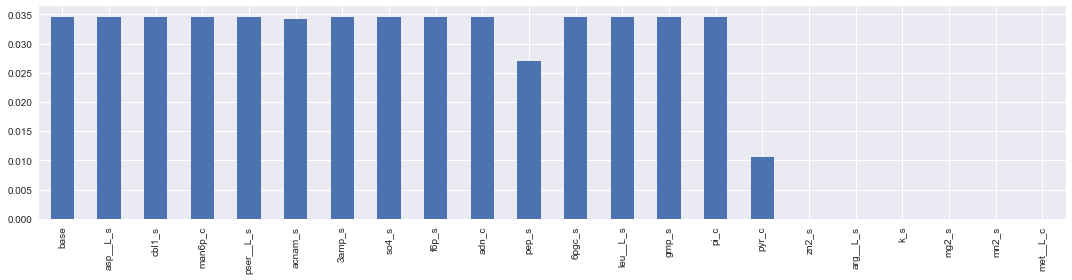

In [87]:
flux_results_df = pd.read_csv('essential_metabolite_group_KO.csv',index_col=0)
flux_results_df.loc['biomass_dilution_s'].plot.bar(figsize=(15,4))
plt.tight_layout()
plt.savefig("essential_metabolite_group_KO.svg", format="SVG")

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,essential_transporters, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
flux_results_df.to_csv('essential_transporter_KO.csv')

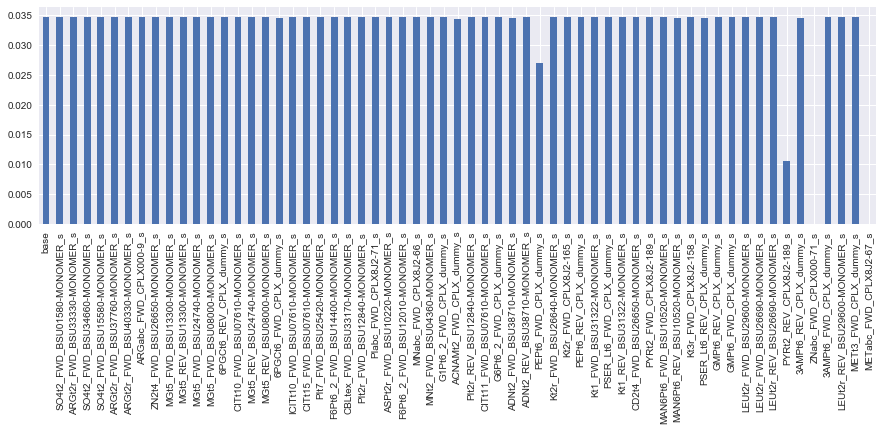

In [48]:
flux_results_df = pd.read_csv('essential_transporter_KO.csv',index_col=0)
flux_results_df.loc['biomass_dilution_s'].plot.bar(figsize=(15,4))

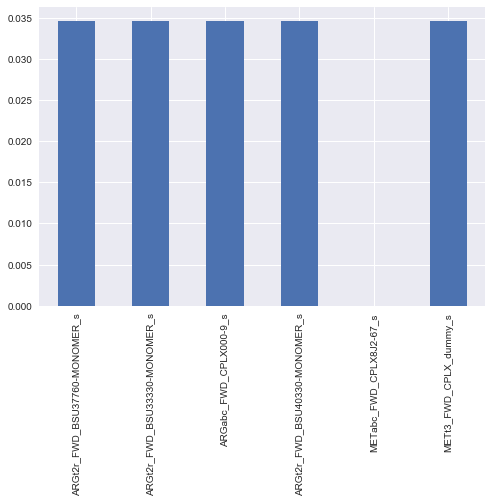

In [53]:
flux_results_df.loc['biomass_dilution_s',at_dict['arg__L_s']+at_dict['met__L_c']].plot.bar()

In [74]:
for r in at_dict['arg__L_s']:
    rxn = sporeme.reactions.get_by_id(r)
    print(rxn.reaction)

arg__L_c + h_c <=> -7.42684631202334e-5*sigma BSU37760-MONOMER_s + arg__L_s + h_s
arg__L_c + h_c <=> -4.27350427350427e-6*sigma BSU33330-MONOMER_s + arg__L_s + h_s
arg__L_c + atp_s + h2o_s <=> -4.27350427350427e-6*sigma CPLX000-9_s + adp_s + arg__L_s + h_s + pi_s
arg__L_c + h_c <=> -4.27350427350427e-6*sigma BSU40330-MONOMER_s + arg__L_s + h_s


### Network visualization

In [50]:
import itertools
import networkx as nx

flux_results_df = pd.read_csv('essential_transporter_KO.csv',index_col=0)

G = nx.Graph()

for r in flux_results_df.drop('base',axis=1).columns:
    rxn = sporeme.reactions.get_by_id(r)
    mets = list(set([m.id[:-2] for m in rxn.metabolites if isinstance(m,cobrame.Metabolite)]))
    combinations = list(itertools.combinations(mets, 2))
    
    for m in mets:
        G.add_node(m,node_size=1000)
    
    for c in combinations:
        G.add_edge(c[0],c[1])

In [51]:
print("Nodes of graph: ")
print(G.nodes())
print("Edges of graph: ")
print(G.edges())

Nodes of graph: 
['so4', 'h', 'arg__L', 'adp', 'atp', 'h2o', 'pi', 'zn2', 'k', 'mg2', '6pgc', 'cit', 'icit', 'na1', 'f6p', 'cbl1', 'asp__L', 'mn2', 'g1p', 'acnam', 'g6p', 'adn', 'pep', 'pser__L', 'cd2', 'pyr', 'man6p', 'gmp', 'leu__L', '3amp', 'met__L']
Edges of graph: 
[('so4', 'h'), ('h', 'arg__L'), ('h', 'adp'), ('h', 'atp'), ('h', 'h2o'), ('h', 'pi'), ('h', 'zn2'), ('h', 'k'), ('h', '6pgc'), ('h', 'mg2'), ('h', 'cit'), ('h', 'icit'), ('h', 'asp__L'), ('h', 'mn2'), ('h', 'acnam'), ('h', 'adn'), ('h', 'pep'), ('h', 'pser__L'), ('h', 'cd2'), ('h', 'pyr'), ('h', 'man6p'), ('h', 'gmp'), ('h', 'leu__L'), ('h', '3amp'), ('h', 'met__L'), ('arg__L', 'adp'), ('arg__L', 'atp'), ('arg__L', 'h2o'), ('arg__L', 'pi'), ('adp', 'atp'), ('adp', 'h2o'), ('adp', 'pi'), ('adp', 'mn2'), ('adp', 'zn2'), ('adp', 'met__L'), ('atp', 'h2o'), ('atp', 'pi'), ('atp', 'mn2'), ('atp', 'zn2'), ('atp', 'met__L'), ('h2o', 'pi'), ('h2o', 'mn2'), ('h2o', 'zn2'), ('h2o', 'met__L'), ('pi', 'na1'), ('pi', 'f6p'), ('pi', 

In [52]:
G.remove_node('cbl1')

In [58]:
pos

{'so4': array([-0.27809808, -0.49195416]),
 'h': array([-0.15168805,  0.02697109]),
 'arg__L': array([0.28499787, 0.14736918]),
 'adp': array([0.25875237, 0.0163389 ]),
 'atp': array([ 0.31793118, -0.08517893]),
 'h2o': array([ 0.22326524, -0.08495193]),
 'pi': array([ 0.52229121, -0.07801026]),
 'zn2': array([0.1256678 , 0.01943615]),
 'k': array([0.04630552, 0.31176186]),
 'mg2': array([-0.27478328, -0.28151426]),
 '6pgc': array([-0.50415023,  0.04938726]),
 'cit': array([-0.03039478, -0.24022903]),
 'icit': array([-0.46014197, -0.2419485 ]),
 'na1': array([0.94084888, 0.14569968]),
 'f6p': array([ 0.84545532, -0.42364881]),
 'asp__L': array([-0.5972213 ,  0.31331184]),
 'mn2': array([ 0.21437143, -0.22774777]),
 'g1p': array([ 1.       , -0.0565255]),
 'acnam': array([-0.0744365 , -0.48984122]),
 'g6p': array([ 0.97465085, -0.25521221]),
 'adn': array([-0.64999835, -0.20451307]),
 'pep': array([-0.3176969 ,  0.53414686]),
 'pser__L': array([-0.35112   ,  0.32418729]),
 'cd2': array(

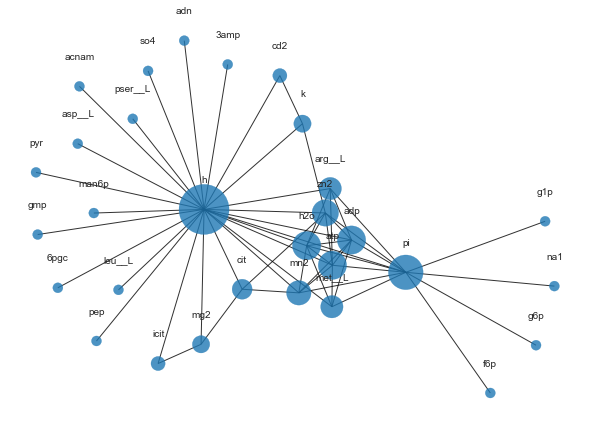

In [85]:
d = dict(G.degree)

pos = nx.spring_layout(G)
nx.draw(G,pos=pos, nodelist=d.keys(), node_size=[v * 100 for v in d.values()],figsize=(13,8),alpha=0.8)

for label in pos.keys():
    x,y = pos[label]
    plt.text(x,y+0.09,s=label,horizontalalignment='center')

plt.draw()
plt.savefig("transport_graph.svg", format="SVG")

#### Pairwise interaction

In [96]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [97]:
for r in transport_reactions:
    if r not in essential_transporters and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [98]:
flux_results_df = pd.read_csv('essential_metabolite_group_KO.csv',index_col=0)
essential_metabolites = flux_results_df.drop('base',axis=1).columns.values
base_model = copy.deepcopy(sporeme)

In [99]:
from scipy.special import binom
print('With {} knockouts there can be {} pairs'.format(len(essential_metabolites),binom(len(essential_metabolites),2)))

With 21 knockouts there can be 210.0 pairs


In [ ]:
from bacillusme.analysis import sensitivity as ss
for met in essential_metabolites:
    # Restore
    sporeme = copy.deepcopy(base_model)
    
    # Close transporter
    for r in at_dict[met]:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.lower_bound = 0
        rxn.upper_bound = 0
    
    # Calculation
    flux_results_df = ss.transporter_knockout(sporeme,essential_metabolites, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout')
    flux_results_df.to_csv('group_transporter_knockouts/{}.csv'.format(met))

Chosen change function: group_knockout      Sequential = False
























  0%|          | 0/21 [00:00<?, ?it/s]





















biomass_dilution_s response (20 threads):   0%|          | 0/21 [00:00<?, ?it/s]

In [102]:
flux_results_df

,base,arg__L_s,zn2_s,so4_s,acnam_s,pser__L_s,6pgc_s,asp__L_s,k_s,gmp_s,...,pyr_c,cbl1_s,mg2_s,pi_c,3amp_s,adn_c,man6p_c,mn2_s,f6p_s,met__L_c
biomass_dilution,0.046832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
protein_biomass_to_biomass,0.026954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mRNA_biomass_to_biomass,0.000092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tRNA_biomass_to_biomass,0.000544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rRNA_biomass_to_biomass,0.004027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Demand_psetha_BS_s,0.112613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Demand_t12dg_BS_s,0.112613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Demand_gtca3_45_BS_s,0.112613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Demand_lipo1_24_BS_s,0.112613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# Read and process
gr_df = pd.DataFrame(index=essential_metabolites)
for m in essential_metabolites:
    flux_results_df=pd.read_csv('group_transporter_knockouts/{}.csv'.format(m),index_col=0).drop('base',axis=1)
    for i in flux_results_df.columns.values:
        gr_df.loc[m,i] = flux_results_df.loc['biomass_dilution_s',i]

<Figure size 936x360 with 0 Axes>

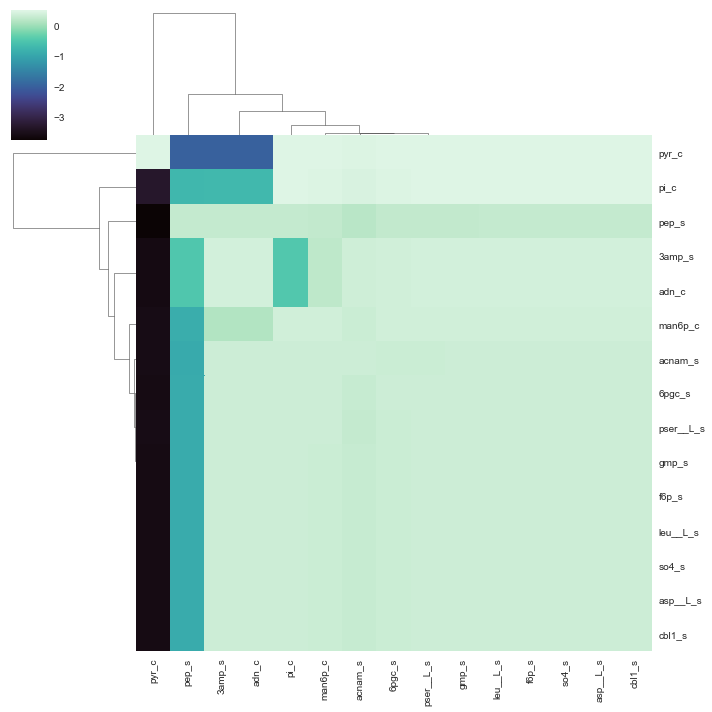

In [105]:
plt.figure(figsize = (13,5))
output = gr_df.loc[gr_df.any(axis=1),gr_df.any(axis=0)]
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1, cmap='mako')

<Figure size 936x360 with 0 Axes>

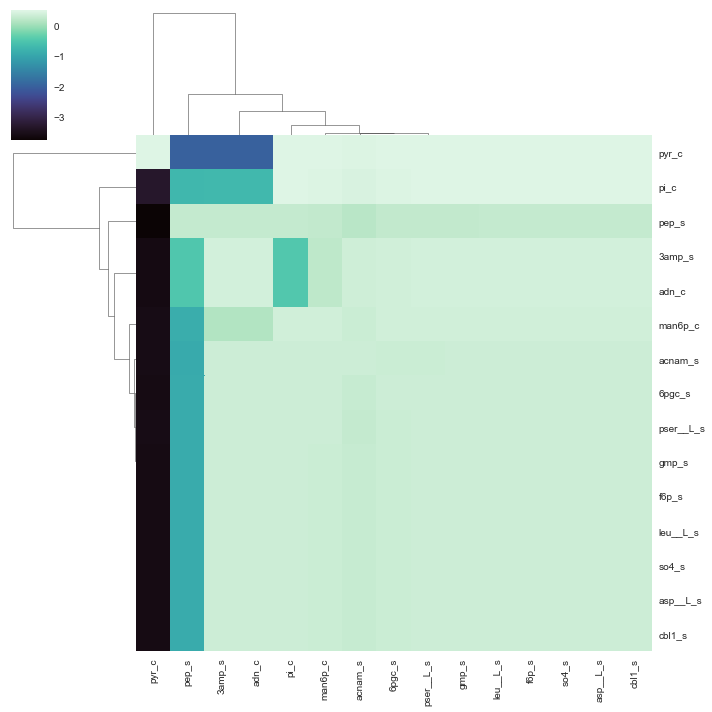

In [111]:
plt.figure(figsize = (13,5))
output = gr_df.loc[gr_df.any(axis=1),gr_df.any(axis=0)]
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1, cmap='mako')

## Energy analysis

In [188]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [189]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results.csv',index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=True).index.to_list()
essential_mets = sorted_mets[:sorted_mets.index('met__L_c')+1]
print('Essential metabolites: {}'.format(essential_mets))

Essential metabolites: ['arg__L_s', 'zn2_s', '6pgc_s', 'so4_s', 'mg2_s', 'pi_c', 'cbl1_s', 'asp__L_s', 'f6p_s', 'mn2_s', 'adn_c', 'acnam_s', 'pep_s', 'pyr_c', 'k_s', 'pser__L_s', 'man6p_c', 'gmp_s', 'leu__L_s', '3amp_s', 'met__L_c']


In [190]:
essential_transporters = []
for met in essential_mets:
    [essential_transporters.append(i) for i in at_dict[met]]

In [191]:
print('{} essential open transporters'.format(len(essential_transporters)))

63 essential open transporters


In [192]:
for r in transport_reactions:
    if r not in essential_transporters and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [ ]:
solve_me_model(sporeme, max_mu = 0.15, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')
flux_dict_base = sporeme.solution.x_dict

iter	muopt    	a     	b     	mu1       	stat1


### Increasing ATPM

In [ ]:
current_ATPM = sporeme.reactions.ATPM_s.lower_bound
new_ATPM = 1.1 * current_ATPM

sporeme.reactions.ATPM_s.lower_bound = new_ATPM
sporeme.reactions.ATPM_s.upper_bound = new_ATPM

In [177]:
solve_me_model(sporeme, max_mu = 0.2, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key='sigma')
flux_dict_ATPM = sporeme.solution.x_dict

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 415.296403 seconds
Finished substituting S,lb,ub in 18.126293 seconds
Finished makeME_LP in 2.265234 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.1 0.1 1
Finished substituting S,lb,ub in 18.146298 seconds
Finished makeME_LP in 2.297373 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.05 0.05 1
Finished substituting S,lb,ub in 18.020615 seconds
Finished makeME_LP in 2.269276 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.025 0.025 1
Finished substituting S,lb,ub in 17.943079 seconds
Finished makeME_LP in 2.261524 seconds
Getting MINOS parameters from ME_NLP...
4 0.0125 0.0125 0.025 0.0125 optimal
Finished substituting S,lb,ub in 17.930481 seconds
Finished makeME_LP in 2.260695 seconds
Getting MINOS parameters from ME_NLP...
5 0.0125 0.0125 0.018750000000000003 0.018750000000000003 1
Finished substituting S,lb,ub in 18.196980 seconds
Finished makeME_LP in 2.283978 second

In [199]:
atp_df = pd.DataFrame.from_dict({'flux':flux_dict_base}).join(pd.DataFrame.from_dict({'flux':flux_dict_ATPM}),rsuffix='_atp')
atp_df.loc['ATPM_s']

flux        11.979
flux_atp     9.900
Name: ATPM_s, dtype: float64

In [215]:
sums = atp_df.loc[at_dict[met]].sum(axis=0)
sums.any()

True

## 

In [218]:

for met in at_dict.keys():
    sums = atp_df.loc[at_dict[met]].sum(axis=0)
    if sums.any():
        ratio = sums['flux_atp']/sums['flux']
        print(met,ratio)

mg2_s 1.369556359552247
gmp_s 1.3936761015209471
pyr_c 0.9235568354626225
k_s 1.402986049062581
man6p_c 1.4041387607925155
arg__L_s 1.3820070949439316
met__L_c 1.3367661897406746
mn2_s 1.3274067919517458
acnam_s 1.410649664782645
pep_s 0.9219755938517683
so4_s 1.3508168559868865
zn2_s 1.9776180944903203
adn_c 0.9206735465435527
3amp_s 0.9206362189827443
pser__L_s 1.431980366328135
6pgc_s 1.404908804372569
leu__L_s 1.3894840437357847


## Metabolites in medium

In [ ]:
[fed_mets = m for m in at_dict.keys() if m]

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,fed_mets, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='feed_metabolites')

Chosen change function: feed_metabolites      Sequential = False














































  0%|          | 0/38 [00:00<?, ?it/s]











































biomass_dilution_s response (10 threads):   0%|          | 0/38 [00:00<?, ?it/s]

In [225]:
flux_results_df

,base,gly_s,nac_s,cit_s,amp_s,citr__L_s,asn__L_s,acac_s,cmp_s,ump_s,...,ala__D_s,glu__L_s,pnto__R_s,dad_2_s,ribflv_s,3amp_s,ala__L_s,6pgc_s,pser__L_s,leu__L_s
biomass_dilution,0.012078,0.012073,0.012052,0.012060,0.012035,0.012056,0.012061,0.012064,0.012043,0.012044,...,0.012067,0.012055,0.012034,0.012034,0.011992,0.012036,0.012067,0.012054,0.012067,0.012050
protein_biomass_to_biomass,0.007074,0.007072,0.007059,0.007064,0.007049,0.007061,0.007065,0.007066,0.007054,0.007055,...,0.007068,0.007061,0.007049,0.007049,0.007024,0.007050,0.007068,0.007060,0.007068,0.007058
mRNA_biomass_to_biomass,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,...,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020
tRNA_biomass_to_biomass,0.000119,0.000119,0.000119,0.000119,0.000118,0.000119,0.000119,0.000119,0.000118,0.000118,...,0.000119,0.000119,0.000118,0.000118,0.000118,0.000118,0.000119,0.000119,0.000119,0.000119
rRNA_biomass_to_biomass,0.000879,0.000879,0.000877,0.000878,0.000876,0.000877,0.000878,0.000878,0.000876,0.000876,...,0.000878,0.000877,0.000876,0.000876,0.000872,0.000876,0.000878,0.000877,0.000878,0.000877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Demand_t12dg_BS_s,0.030711,0.030701,0.030658,0.030674,0.030608,0.030663,0.030672,0.030684,0.030635,0.030640,...,0.030691,0.030657,0.030620,0.030610,0.030513,0.030612,0.030691,0.030661,0.030687,0.030656
Demand_gtca3_45_BS_s,0.030711,0.030701,0.030658,0.030674,0.030608,0.030663,0.030672,0.030684,0.030635,0.030640,...,0.030691,0.030657,0.030620,0.030610,0.030513,0.030612,0.030691,0.030661,0.030687,0.030656
Demand_lipo1_24_BS_s,0.030711,0.030701,0.030658,0.030674,0.030608,0.030663,0.030672,0.030684,0.030635,0.030640,...,0.030691,0.030657,0.030620,0.030610,0.030513,0.030612,0.030691,0.030661,0.030687,0.030656
Demand_tcam_BS_s,0.539554,0.539392,0.538664,0.538933,0.537795,0.538743,0.538900,0.539076,0.538259,0.538332,...,0.539224,0.538640,0.537977,0.537838,0.536119,0.537875,0.539226,0.538711,0.539156,0.538619
